# Zero Cross-lingual Topic Modeling

### Fashionable to Be Dumb? A Gender Analysis of STEM Discourse in Latin American Social Media

We are going to use our Zero-Shot Topic Model to get the topics out of a collections of articles you will upload here. Then, we are going to predict the topics of unseen documents in an unseen language exploiting the multilingual capabilities of Multilingual BERT.

### Install libraries

In [ ]:
%%capture
!pip install contextualized-topic-models

In [ ]:
%%capture
!pip install pandas==1.2.5

In [ ]:
%%capture
!pip install pyldavis

### Import libraries

In [ ]:
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

import pandas as pd

### Load Data

In [ ]:
ds_esp = pd.read_csv("/content/ds_esp_2019_2021.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
ds_esp["final_tweet"] = ds_esp["final_tweet"].astype(str)

### Preprocessing

We need text without punctuation to build the bag of word. Also, we might want only to have the most frequent words inside the BoW. Too many words might not help.

In [ ]:
%%capture
nltk.download('stopwords')

In [ ]:
documents = ds_esp["final_tweet"].to_numpy().flatten()
sp = WhiteSpacePreprocessing(documents, stopwords_language=['spanish','english'])
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

In [ ]:
preprocessed_documents[:2]
#unpreprocessed_corpus[:2]
vocab[:10]

['aprender',
 'viaje',
 'cree',
 'leyes',
 'facultad',
 'equitativa',
 'celular',
 'unido',
 'felicitaciones',
 'suficiente']

### Export to be used by OCTIS

#### Corpus

In [ ]:
with open('corpus.csv', 'w') as f:
    for item in preprocessed_documents:
        f.write("%s\n" % item)

#### Vocabulary

In [ ]:
vocab = open("vocabulary.txt", "r")
#print(vocab.read()) 
type(vocab)


In [ ]:
preprocessed_documents = pd.read_csv("/content/corpus.csv")
preprocessed_documents

### Topic Model Preparation

In [ ]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased")
#tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

In [ ]:
with open('vocabulary_fit2.txt', 'w') as f:
    for item in vocab:
        f.write("%s\n" % item)

In [ ]:
len(tp.vocab)

1981

### Training our Zero-Shot Contextualized Topic Model

In [ ]:
vocab = pd.read_csv("/content/vocab_fit.txt")
len(vocab)

1980

In [ ]:
ctm = ZeroShotTM(bow_size=len(tp.vocab),
                 contextual_size=512, 
                 n_components=10, 
                 num_epochs=30,
                 model_type = "prodLDA",
                 activation = "softplus",
                 dropout = 0.6528626452408228,
                 hidden_sizes=(100,100,100)
                 )
ctm.fit(training_dataset) # run the model

Epoch: [30/30]	 Seen Samples: [5909730/5909730]	Train Loss: 66.1471045477847	Time: 0:00:38.380061: : 30it [19:26, 38.89s/it]


### Topics

In [ ]:
ctm.get_topic_lists(10)
df_topics = pd.DataFrame(ctm.get_topic_lists(30))
df_topics.to_csv("Words_per_Topic_30.csv", index = False) 

### Visualization

In [ ]:
 lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [05:22, 32.21s/it]


In [ ]:
import pyLDAvis as vis
stem_pd = vis.prepare(**lda_vis_data)
vis.display(stem_pd)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

In [ ]:
vis.save_html(stem_pd, 'ctm_optimizado2.html')

### Topic Prediction

In [ ]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=10) # get all the topic predictions

Sampling: [10/10]: : 10it [05:24, 32.46s/it]


In [ ]:
topics1 = ctm.get_predicted_topics(dataset=training_dataset, n_samples=10)
topics2 = ctm.get_topic_lists()


In [ ]:
topics3 = ctm.get_doc_topic_distribution(training_dataset)


In [ ]:
topic4 = ctm.get_most_likely_topic(topics3)

In [ ]:
print(len(preprocessed_documents))
print(len(unpreprocessed_corpus))
d = {'Tweet':unpreprocessed_corpus,'Topic':topics1}
df = pd.DataFrame(d)
df

196991
196991


,Tweet,Topic
0,🔵 La característica física de los hombres que ...,4
1,Y Gravity brutal con la mami Sandra Bullock ...,3
2,Seguro que hay varios ejemplos de concursante...,3
3,Afinan agenda legislativa en favor de niñas y ...,7
4,No se hagan pendejas si el diablo es el diabl...,9
...,...,...
196986,TomaNota || En la las mujeres venezolanas ...,4
196987,Que si el trabajo requiere fuerza para ser r...,8
196988,No es necesario que vengas de ingeniería ten...,3
196989,Pues veo a los seres humanos por sus valore...,3


### Merge Dataset

In [ ]:
df['Topic_distribution'] = topics3.tolist()
df

array([[0.05118026, 0.0300634 , 0.0464551 , ..., 0.08080942, 0.1316746 ,
        0.03755083],
       [0.02785309, 0.12176286, 0.03922624, ..., 0.04965949, 0.055619  ,
        0.17915533],
       [0.04566008, 0.04236403, 0.02887807, ..., 0.0374091 , 0.09061265,
        0.07762971],
       ...,
       [0.02816307, 0.05471136, 0.03707925, ..., 0.01614069, 0.04541794,
        0.07143183],
       [0.02429318, 0.05235894, 0.04280008, ..., 0.03263136, 0.18402546,
        0.3564711 ],
       [0.15622106, 0.0287469 , 0.02635814, ..., 0.04929582, 0.53166908,
        0.07708684]])

In [ ]:
df['topic_labels'] = df["Topic"].apply(lambda row: ctm.get_topic_lists(10)[row-1])
df

In [ ]:
df.to_csv("Topic_database_topic_prediction.csv", index = False)

In [ ]:
df_empty = pd.DataFrame({'Topic_distribution' : []})

df_empty['Topic_distribution'] = topics3.tolist()
df_empty.to_csv("Topic_distribution.csv", index=False)

## Imports

### Unseen languages

In [ ]:
df_pt = pd.read_csv("ds_pt_2019_2021.csv")
df_pt

In [29]:
portuguese_documents = df_pt["final_tweet"].to_numpy().flatten()
portuguese_documents

array(['    sim o fã da demi lovato que sabe fazer conta básica de matemática... já sei amigo diz que a mulher ganhou 7 grammys e posta uma foto da mesma segurando 5 E AINDA ACHA QUE ESTÁ ABAFANDO',
       ' é  mas nao chegava a ser uma indústria  e era uma preocupação da mulher ocidental e de classe alta  beleza nao era uma preocupação enorme pra mulher q trabalha pra caralho tinha 30 filhos e umas 7 doenças',
       'Como diz a menina que pega química comigo “de dia é um sol pra cada um e de noite é um calor pra cada um”',
       ...,
       'tem uma menina aqui no prédio que é tão chata que as outras crianças só devem chamar ela pra brincar pq os pais mandam pq eles mesmos dizem na cara dela que ela é chata kkkkkk',
       'tava na sacada fazendo carinho no meu gato e quando olhei pro predio da frente tinha uma menina tirando foto minha (?)',
       'a hailey é uma das mulheres mais maduras e sensatas q já vi nessa indústria de famosos. infelizmente ngm tá pronto pra lidar com ela s

In [32]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased")

testing_dataset = tp.transform(portuguese_documents) # create dataset for the testset


/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:84: UserWarning: The method did not have in input the text_for_bow parameter. This IS EXPECTED if you are using ZeroShotTM in a cross-lingual setting
  warnings.warn("The method did not have in input the text_for_bow parameter. This IS EXPECTED if you "


  0%|          | 0.00/504M [00:00<?, ?B/s]

Batches:   0%|          | 0/261 [00:00<?, ?it/s]

### Topic Prediction

In [33]:
# n_sample how many times to sample the distribution (see the documentation)
portuguese_topics_predictions = ctm.get_thetas(testing_dataset, n_samples=10) # get all the topic predictions


Sampling: [10/10]: : 10it [01:01,  6.11s/it]


In [34]:
import numpy as np

topic_number = np.argmax(portuguese_topics_predictions[0]) # get the topic id of the first document
ctm.get_topic_lists(10)[topic_number] 

['chica',
 'chicas',
 'cosas',
 'bien',
 'mal',
 'dijo',
 'ver',
 'si',
 'siempre',
 'creo']

In [35]:
import numpy as np

aux = []

for elements in portuguese_topics_predictions:
  aux.append(np.argmax(elements))
len(aux)


52062

In [39]:
topics7 = ctm.get_predicted_topics(dataset=testing_dataset, n_samples=10)
topics8 = ctm.get_topic_lists()

Sampling: [10/10]: : 10it [01:00,  6.09s/it]


In [43]:
topics9 = ctm.get_doc_topic_distribution(testing_dataset)


Sampling: [20/20]: : 20it [02:02,  6.13s/it]


In [44]:
topics9

array([[0.02908382, 0.10261941, 0.03130493, ..., 0.04079803, 0.07851503,
        0.1143296 ],
       [0.06568528, 0.08025909, 0.04353456, ..., 0.19957248, 0.17663955,
        0.0712463 ],
       [0.0556357 , 0.04385201, 0.02489246, ..., 0.04020974, 0.04095262,
        0.05732255],
       ...,
       [0.01831331, 0.02885267, 0.02606107, ..., 0.03500829, 0.03325393,
        0.0444526 ],
       [0.02072929, 0.07910791, 0.02804957, ..., 0.03266119, 0.03949104,
        0.03083001],
       [0.03764074, 0.0979933 , 0.03838959, ..., 0.09400661, 0.08518483,
        0.22883447]])

In [45]:
d = {'Tweet':portuguese_documents,'Topic':aux}
df_p = pd.DataFrame(d)
df_p

,Tweet,Topic
0,sim o fã da demi lovato que sabe fazer con...,3
1,é mas nao chegava a ser uma indústria e era...,8
2,Como diz a menina que pega química comigo “de ...,3
3,que indústria mulher? baixei tudokkkkkkk,4
4,menina tô com medo de largar o meu curso de ...,3
...,...,...
52057,Que maravilha! Imagino o orgulho dos pais de ...,1
52058,Off: Lembrei de um dia no 7° ano quando eu ain...,3
52059,tem uma menina aqui no prédio que é tão chata ...,3
52060,tava na sacada fazendo carinho no meu gato e q...,4


In [46]:
df_p['topic_labels'] = df_p["Topic"].apply(lambda row: ctm.get_topic_lists(10)[row - 1])


In [48]:
## Merge topic prediction
df_p['Topic_distribution'] = topics9.tolist()
df_p

,Tweet,Topic,topic_labels,Topic_distribution
0,sim o fã da demi lovato que sabe fazer con...,3,"[internacional, ciencia, febrero, plena, hoy, ...","[0.029083820048253984, 0.10261941424105317, 0...."
1,é mas nao chegava a ser uma indústria e era...,8,"[sexual, derechos, violencia, ambiente, indust...","[0.06568527545314282, 0.08025909315329045, 0.0..."
2,Como diz a menina que pega química comigo “de ...,3,"[internacional, ciencia, febrero, plena, hoy, ...","[0.05563570249796612, 0.04385200980759692, 0.0..."
3,que indústria mulher? baixei tudokkkkkkk,4,"[chica, chicas, cosas, bien, mal, dijo, ver, s...","[0.044243719184305516, 0.1595531371422112, 0.0..."
4,menina tô com medo de largar o meu curso de ...,3,"[internacional, ciencia, febrero, plena, hoy, ...","[0.0496931190311443, 0.0844531651615398, 0.026..."
...,...,...,...,...
52057,Que maravilha! Imagino o orgulho dos pais de ...,1,"[stem, carreras, mujeres, saruhashi, igualdad,...","[0.10007457373430953, 0.2569364382885396, 0.06..."
52058,Off: Lembrei de um dia no 7° ano quando eu ain...,3,"[internacional, ciencia, febrero, plena, hoy, ...","[0.027490507671609522, 0.025782084657112136, 0..."
52059,tem uma menina aqui no prédio que é tão chata ...,3,"[internacional, ciencia, febrero, plena, hoy, ...","[0.018313313322141766, 0.028852669050684197, 0..."
52060,tava na sacada fazendo carinho no meu gato e q...,4,"[chica, chicas, cosas, bien, mal, dijo, ver, s...","[0.020729285787092523, 0.07910791374742984, 0...."


In [53]:
df_p.to_csv("Topic_database_topic_prediction_pt.csv", index = False)


In [56]:
df_empty2 = pd.DataFrame({'Topic_distribution' : []})

df_empty2['Topic_distribution'] = topics9.tolist()
df_empty2
df_empty2.to_csv("Topic_distribution_pt.csv", index=False)

In [57]:
df_empty2

,Topic_distribution
0,"[0.029083820048253984, 0.10261941424105317, 0...."
1,"[0.06568527545314282, 0.08025909315329045, 0.0..."
2,"[0.05563570249796612, 0.04385200980759692, 0.0..."
3,"[0.044243719184305516, 0.1595531371422112, 0.0..."
4,"[0.0496931190311443, 0.0844531651615398, 0.026..."
...,...
52057,"[0.10007457373430953, 0.2569364382885396, 0.06..."
52058,"[0.027490507671609522, 0.025782084657112136, 0..."
52059,"[0.018313313322141766, 0.028852669050684197, 0..."
52060,"[0.020729285787092523, 0.07910791374742984, 0...."


### Save Model

In [ ]:
ctm.save(models_dir="./")

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/models/ctm.py:415: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


## Visualizations

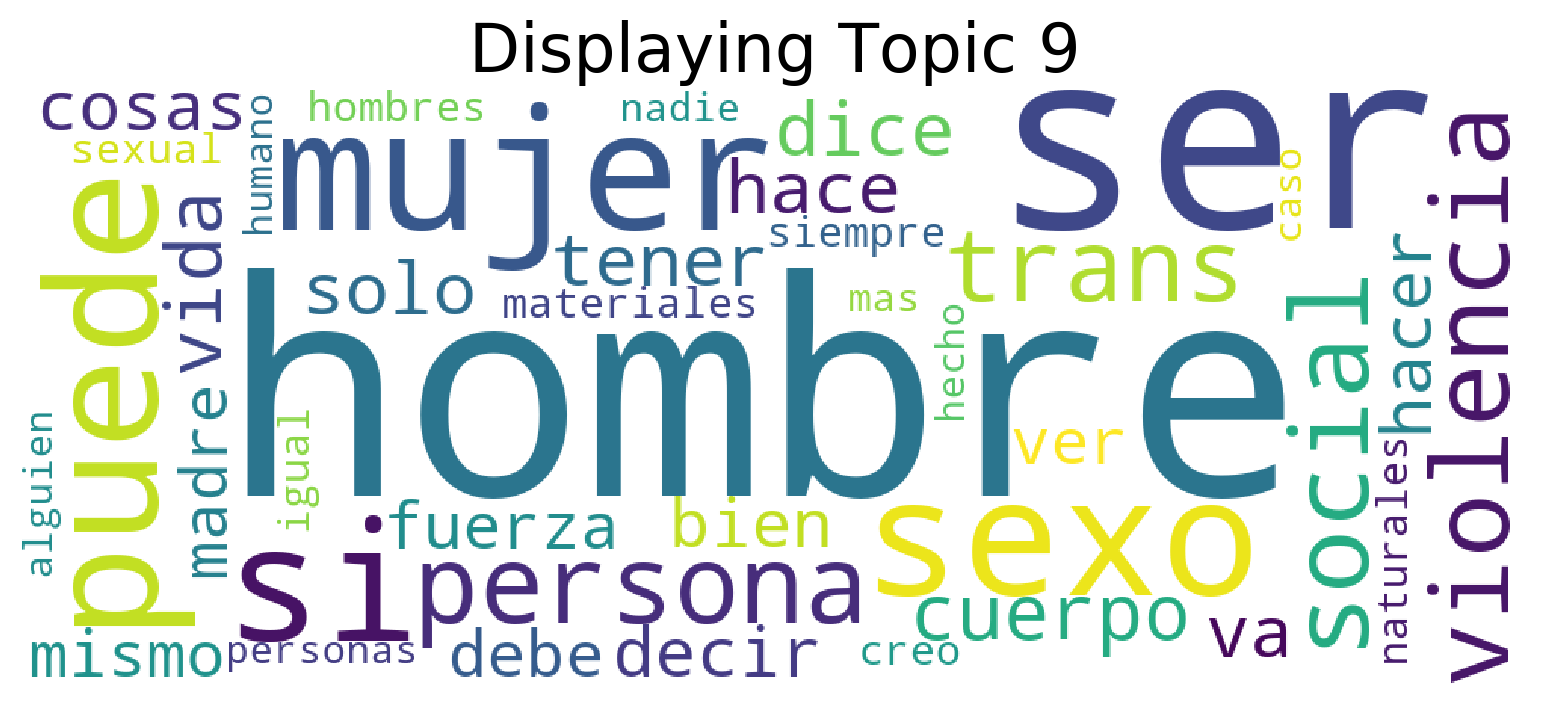

In [ ]:
ctm.get_wordcloud(9,n_words=40,background_color="white")

In [ ]:
tp_w_m = ctm.get_topic_word_matrix()
df_tp = pd.DataFrame(tp_w_m)
df_tp.to_csv("Topic_word_matrix.csv", index = False)

In [ ]:
topics = ctm.get_topics()
d = {'Topics':topics}
topics_df = pd.DataFrame(d)
topics_df.to_csv("Topics.csv", index=False)


In [ ]:
ctm.get_most_likely_topic(doc_topic_distribution=topics3)

array([149723, 183290,  22830, 135271,  18654,  25778, 136570, 170502,
       154311,  85224])

In [ ]:
import json
res = json.load(open("result.json",'r'))
res.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='result.json' mode='r' encoding='UTF-8'>
  


dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

In [ ]:
res['x_iters']['activation']

['relu',
 'softplus',
 'softplus',
 'relu',
 'relu',
 'relu',
 'relu',
 'relu',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'softplus']

In [ ]:
res["f_val"]

[-0.012696563489589929,
 0.05897518467201388,
 0.09764432158527746,
 0.03325646498718681,
 -0.010605091138006256,
 -0.013034346318947954,
 0.0001274738384572576,
 0.026845095309759075,
 0.10034473768889023,
 0.0684881494880597,
 0.019186981499777364,
 0.07814368834514229,
 0.09009253740505901,
 0.13083181181227352,
 0.079152198172026,
 0.0770071020984817,
 0.12020691795739855,
 0.07501535182346523,
 0.07204116320827589,
 0.07955485832140077,
 0.10674771374324746,
 0.0770850920407112,
 0.09114470531326471,
 0.12135515938870212,
 0.08592797544504167,
 0.06275972380628435,
 0.10379583911538526,
 0.1182030964387675,
 0.0508371731843613,
 0.09071049920663729]

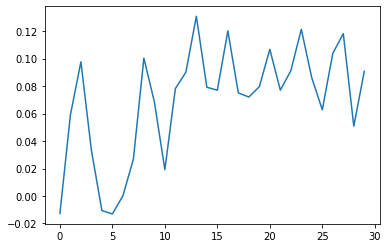

In [ ]:
import matplotlib.pyplot as plt

plt.plot(res["f_val"])

### Load Model

In [ ]:
ctm = ZeroShotTM(bow_size=len(content_list),
                 contextual_size=512, 
                 n_components=10, 
                 num_epochs=30,
                 model_type = "prodLDA",
                 activation = "softplus",
                 dropout = 0.6528626452408228,
                 hidden_sizes=(100,100,100)
                 )



In [27]:
ctm.load("/content/test", epoch=29)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/models/ctm.py:440: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


In [ ]:
my_file = open("vocabulary.txt", "r")

content = my_file.read()

content_list = content.split("\n")

my_file.close()

print(content_list)


['aprender', 'viaje', 'cree', 'leyes', 'facultad', 'equitativa', 'celular', 'unido', 'felicitaciones', 'suficiente', 'cosas', 'colombianas', 'hacia', 'capitalismo', 'tipos', 'leer', 'impulsando', 'cuesta', 'claramente', 'amiga', 'aprobado', 'conoce', 'interior', 'causa', 'cientifica', 'decirle', 'actividades', 'brasil', 'doy', 'conocida', 'plata', 'gustos', 'medida', 'dedica', 'para', 'celebramos', 'orgullo', 'marketing', 'sienten', 'crecer', 'luna', 'seis', 'aportan', 'experiencia', 'futuro', 'enhorabuena', 'alianzasteam', 'ves', 'genero', 'minera', 'primer', 'estudiando', 'alma', 'sentir', 'honor', 'nina', 'logrado', 'forma', 'equitativo', 'huelga', 'youtube', 'cambia', 'viajar', 'miles', 'tiempo', 'une', 'titular', 'embarazada', 'gustan', 'potencial', 'reto', 'secretaria', 'apoyamos', 'ganas', 'difundir', 'vivo', 'vayan', 'diversos', 'cara', 'vida', 'entorno', 'bajo', 'cultura', 'hrs', 'embargo', 'grado', 'cae', 'matematicas', 'hija', 'sexualidad', 'sabe', 'destacar', 'estereotipos'

In [ ]:
len(content_list)

2001